## Estimating rotors using dual quaternions 

This is a comparison between the method developed in pygacal and the method presented by Bayro-Corrochano et.al. in [Motor Algebra for 3D Kinematics: The Case of the Hand-Eye Calibration](https://link.springer.com/article/10.1023%2FA%3A102656781298). 

Representing lines as 

$$ L = n + I m $$

$$ n = x_2 - x_1 $$

$$ m = x_1 \times x_2 $$

We then set up the relation for a pair of lines $L_1 = a + I a'$ and $L_2 = b + I b'$ transformed with the rotor $M = R + I R'$. 

$$ \
\begin{bmatrix} 
    a - b & [a + b]_{\times} & 0_{3 \times 1} & 0_{3 \times 1} \\
    a' - b' & [a' + b']_{\times} & a - b & [a + b]_{\times} \\
\end{bmatrix} \begin{bmatrix} 
    R \\
    R'
\end{bmatrix} = \begin{bmatrix} 
    0 \\ 
    0
\end{bmatrix} $$

$$
    \Rightarrow \begin{bmatrix} 
    C_1 \\
    \vdots \\
    C_N
\end{bmatrix} \begin{bmatrix} 
    R \\
    R'
\end{bmatrix} = \begin{bmatrix} 
    0 \\ 
    0
\end{bmatrix}
$$

$$ \Rightarrow D \begin{bmatrix} 
    R \\
    R'
\end{bmatrix} = \begin{bmatrix} 
    0 \\ 
    0
\end{bmatrix}$$

$$ D = U \Sigma V^T $$

$\Sigma$ should have two and only two small singular values. 

Let $v_7 = \begin{bmatrix} u_1 \\ v_1 \end{bmatrix} $ and $v_8 = \begin{bmatrix} u_2 \\ v_2 \end{bmatrix} $ 

Solve the set of equations for $ \alpha \neq 0 $ and $ \beta \neq 0$: 

\begin{align}
    \alpha^2 u_1^T u_1 + 2 \alpha \beta  u_1^T u_2 + \beta^2  u_2^T u_2 &= 1 \\
    \alpha^2 u_1^T v_1 + \alpha \beta ( u_1^T v_2 + v_1^T u_2) + \beta^2  u_2^T u_2 &= 1 
\end{align}

Choose largest $\beta$ as our solution. Sign does not matter. 

$$ \Rightarrow \begin{bmatrix} 
    R \\
    R'
\end{bmatrix} = \alpha v_7 + \beta v_8 $$

$R$ is a quaternion representing the rotation
$R'$ can be converted to $t$

$$ \begin{bmatrix} 0 \\t \end{bmatrix}  = - 2 R' \tilde{R} $$ (quaternion multiplication)


In [4]:
from pygacal.common.cgatools import *
from pygacal.geometry import *
from pygacal.geometry.lines import *
from pygacal.geometry.transformations import * 
from pygacal.rotation.mapping import BivectorLineMapping
from pygacal.rotation import minimizeError
from pygacal.rotation.costfunction import rotorAbsCostFunction

import time

import numpy as np


ImportError: No module named 'pygacal'

In [2]:


def cross_product(a):
    return np.array([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])

def dual_quat_line(x_1, x_2):
    n = x_2 - x_1
    m = np.cross(x_1, x_2)
    return n, m

def D_matrix(a, ad, b, bd):
    D = np.zeros((6, 8))
    D[:3, 0]   = a - b
    D[:3, 1:4] = cross_product(a + b)
    D[3:, 0]   = ad - bd
    D[3:, 1:4] = cross_product(ad + bd)
    D[3:, 4]   = a - b
    D[3:, 5:] = cross_product(a + b)
    return D


    

In [3]:
sigma_R             = 0.01 
sigma_T             = 0.01
N_train             = 20
line_scale          = 100
translation_scale   = 100

N = N_train

line1, line2 = createRandomLines(2)
a = createRandomVector(scale = translation_scale)
print("Translated lineA by ", a)

b = createRandomVector(scale = translation_scale)
print("Translated lineB by ", b)

T_a = Translator(a)
T_b = Translator(b)

#Move them far away from the origin
lineA = T_a * line1 * ~T_a  
lineB = T_b * line2 * ~T_b  

R_real = RotorLine2Line(lineA, lineB)

traininglinesets    = createNoisyLineSet(R_real, sigma_R, sigma_T, N_train, scale = line_scale)


Translated lineA by  -(84.36154^e1) + (61.54745^e2) + (65.58604^e3)
Translated lineB by  -(47.45976^e1) + (85.55667^e2) + (48.22457^e3)


In [4]:

t0 = time.time()

C = np.zeros((N*6, 8))

for i in range(len(traininglinesets)):
    linepair = traininglinesets[i]
    L1 = linepair[0]
    L2 = linepair[1]    
    a, ma = findLineParams(L1)
    b, mb = findLineParams(L2)
        
    x11 = MVto3DVec(a)
    x12 = MVto3DVec(a) + MVto3DVec(ma)
    x21 = MVto3DVec(b)
    x22 = MVto3DVec(b) + MVto3DVec(mb)
    
    a, ad = dual_quat_line(x11, x12)
    b, bd = dual_quat_line(x21, x22)   
    
    C[6*i:6*(i + 1), :] = D_matrix(a, ad, b, bd)
    
    

U, S, VH = np.linalg.svd(C)

V = VH.transpose()

v7 = V[:, 6]
v8 = V[:, 7]

u1 = v7[:4]
v1 = v7[4:]

u2 = v8[:4]
v2 = v8[4:]

a = np.dot(u1, v1)
b = np.dot(u1, v2) + np.dot(v1, u2)
c = np.dot(u2, v2)

mu_1 = (-b + np.sqrt(b*b - 4 * a * c))/(2 * a)
mu_2 = (-b - np.sqrt(b*b - 4 * a * c))/(2 * a)

a = np.dot(u1, u1)
b = 2 * np.dot(u1, u2) 
c = np.dot(u2, u2)

beta_1 = 1.0 / np.sqrt(mu_1*mu_1 * a + mu_2 * b + c)
beta_2 = 1.0 / np.sqrt(mu_2*mu_2 * a + mu_2 * b + c)

beta = min(beta_1, beta_2)
mu = ([mu_1, mu_2])[np.argmin([[beta_1, beta_2]])]


alpha = mu * beta
r = alpha * v7 + beta * v8


t_diff_edu = time.time() - t0

print(t_diff_edu)

0.1384572982788086


In [5]:
r

array([-7.10992464e-01, -5.53397375e-01,  6.83557577e-02, -4.71796292e-01,
       -5.63839028e+00, -2.57651703e+01, -7.10383299e+01,  2.84261491e+01])

In [6]:
quat = r[:4]
#quat = r[:4]/np.sqrt(np.dot(r[:4], r[:4]))
#print(quat)
angles = quaternion_to_rotation(quat) 
print(angles)

[-1.11519608 -0.43894068 -0.9065478 ]


In [7]:
#dual_quat = r[4:]/np.sqrt(np.dot(r[4:], r[4:]))
#print(dual_quat)
dual_quat = r[4:]

def quaternion_mult(q,r):
    w0, x0, y0, z0 = q
    w1, x1, y1, z1 = r
    return np.array([-x1*x0 - y1*y0 - z1*z0 + w1*w0,
                         x1*w0 + y1*z0 - z1*y0 + w1*x0,
                        -x1*z0 + y1*w0 + z1*x0 + w1*y0,
                         x1*y0 - y1*x0 + z1*w0 + w1*z0], dtype=np.float64)

def quat_conjugate(quat):
    return np.array([quat[0],-1*quat[1],-1*quat[2],-1*quat[3]])

t = -2 * quaternion_mult(dual_quat, quat_conjugate(quat))

translation = t[1:]
print(translation)

R_Eduardo = parameters_to_versor(angles, translation)



[-93.5422023  -46.01253111 127.88914489]


In [8]:
def bivector_difference(R_true, R_test):
    B_true = ga_log(R_true)
    B_test = ga_log(R_test) 
    return rotorAbsCostFunction(ga_exp(B_test - B_true))
    

In [9]:
##Boosted with starting point:

t0 = time.time()

x0 = BivectorLineMapping.inverserotorconversion(R_Eduardo)

R_min_boost, nit_boost = minimizeError(traininglinesets, mapping = BivectorLineMapping, x0 = x0)   

print(bivector_difference(R_real, R_min_boost))

print(nit_boost)
t_diff_boost = time.time() - t0 + t_diff_edu
print(t_diff_boost)

0.31809048206427365
46
3.495171070098877


In [10]:

## Normal

t0 = time.time()

R_min, nit = minimizeError(traininglinesets, mapping = BivectorLineMapping, x0 = None)   

print(nit)


t_diff = time.time() - t0
print(t_diff)

57
3.692878007888794


In [11]:
print(versor_to_param(R_real))
print(bivector_difference(R_real, R_real))

(array([-1.11854124, -0.42882305, -0.9120788 ]), array([-89.85426931, -42.976977  , 122.85294995]))
0.0


In [12]:
print(versor_to_param(R_Eduardo))
print(bivector_difference(R_real, R_Eduardo))

(array([-1.11519608, -0.43894068, -0.9065478 ]), array([-93.5422023 , -46.01253111, 127.88914489]))
15.257579731435317


In [13]:
print(versor_to_param(R_min))
print(bivector_difference(R_real, R_min))

(array([-1.11677078, -0.42859016, -0.90755294]), array([-89.59489535, -44.24423129, 122.85226635]))
0.31810718122061854


In [14]:
print(N, sigma_T, sigma_R)
print()
print(bivector_difference(R_real, R_Eduardo), t_diff_edu)
print(bivector_difference(R_real, R_min), t_diff, nit, t_diff_boost, nit_boost)

20 0.01 0.01

15.257579731435317 0.1384572982788086
0.31810718122061854 3.692878007888794 57 3.495171070098877 46


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np




In [75]:
data = np.genfromtxt('comparison.txt', delimiter=',')


In [69]:
print(data[:, 1])

[  10.   15.   20.   50.   70.  100.  150.  200.   10.   15.   20.   50.
   70.  100.  150.  200.   10.   15.   20.   50.   70.  100.  150.  200.
   10.   15.   20.   50.   70.  100.  150.  200.   15.   20.   50.   70.
  100.  150.  200.   10.   15.   20.   50.   70.  100.  150.  200.   10.
   15.   20.   50.   70.  100.  150.  200.   10.   15.   20.   50.   70.
  100.  150.  200.   10.   15.   20.   50.   70.  150.  200.   10.   15.
   20.   50.   70.  100.  150.]


(-4.5, -0.5)

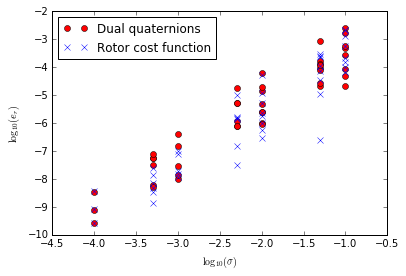

In [76]:
plt.plot(np.log10(data[:, 0]), np.log10(data[:, 2]), 'ro', np.log10(data[:, 0]), np.log10(data[:, 4]), 'bx')
plt.legend(["Dual quaternions", "Rotor cost function"], loc = 2)
plt.xlabel("$ \\log_{10}(\\sigma) $")
plt.ylabel("$ \\log_{10}(e_r) $")
plt.xlim(left = -4.5, right = -0.5)

(-4.5, -0.5)

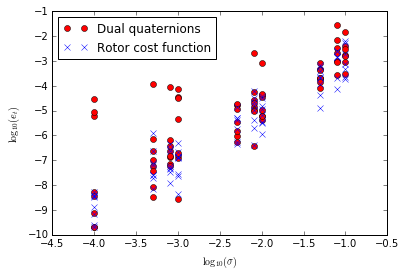

In [71]:
plt.plot(np.log10(data[:, 0]), np.log10(data[:, 3]), 'ro', np.log10(data[:, 0]), np.log10(data[:, 5]), 'bx')
plt.legend(["Dual quaternions", "Rotor cost function"], loc = 2)
plt.xlabel("$ \\log_{10}(\\sigma) $")
plt.ylabel("$ \\log_{10}(e_t) $")
plt.xlim(left = -4.5, right = -0.5)